In [37]:
import json

from matplotlib import pyplot as plt
import numpy as np

TOTAL_TESTS = 0
DISCREPANT_TESTS = 0
DISCREPANT_METHODS = []
METHODS_COUNT = {}
TEST_METHOD_MAP = {}
DISCREPANT_TEST_METHOD_MAP = {}

def get_methods_from_file(file_path):
    
    with open(file_path, "r") as f:
        methods = f.read().splitlines()

    return methods



def find_tests_with_methods(methods_json_path, methods, app_name):
    global DISCREPANT_TESTS
    global TOTAL_TESTS
    global METHODS_COUNT
    global TEST_METHOD_MAP
    global DISCREPANT_METHODS
    
    with open(methods_json_path, "r") as f:
        json_data = json.load(f)

    tests = json_data.keys()

    app_tests = 0
    for i in tests:
        if not json_data[i] == []: # remove tests with no cloud methods
            app_tests += 1

    tests_with_methods = []
    test_methods_count = {}
    discrepant_methods = []
    test_methods_map = {}
    for key, value in json_data.items():
        for i in value:
            if i in test_methods_count:
                test_methods_count[i] += 1
            else:
                test_methods_count[i] = 1
        for method in methods:
            if method in value:
                # print(method)
                if not method in discrepant_methods:
                    discrepant_methods.append(method)
                if not key in tests_with_methods:
                    tests_with_methods.append(key)

                if not method in DISCREPANT_METHODS:
                    DISCREPANT_METHODS.append(method)
                
                if not key in TEST_METHOD_MAP:
                    TEST_METHOD_MAP[key] = [method]
                else:
                    TEST_METHOD_MAP[key].append(method)

                if not key in test_methods_map:
                    test_methods_map[key] = [method]
                else:
                    test_methods_map[key].append(method)
                # no need to check for other discrepant methods in this test hence break
                # break

    for i in test_methods_count:
        if i in METHODS_COUNT:
            METHODS_COUNT[i] += test_methods_count[i]
        else:
            METHODS_COUNT[i] = test_methods_count[i]

    print(f'Method counts: {json.dumps(test_methods_count, indent=2)}')
    print(f'Unique API methods: {len(test_methods_count)}')
    print(f'Discrepant Unique APIs: {len(discrepant_methods)}')
    print(f'Discrepant APIs: \n{[(i,test_methods_count[i]) for i in discrepant_methods]}')
    print(f'Potential discrepant tests: {len(tests_with_methods)}')
    print(f'Total tests: {app_tests}\n\n')

    DISCREPANT_TESTS += len(tests_with_methods)
    TOTAL_TESTS += app_tests
    test_methods_count = {k: v for k, v in test_methods_count.items() if k in DISCREPANT_METHODS}
    test_methods_count = {k: v for k, v in sorted(test_methods_count.items(), key=lambda item: item[1], reverse=True)}
    y_axis = []
    # y_axis.append(len([j for j in TEST_METHOD_MAP.keys() if not TEST_METHOD_MAP[j] == []]))
    for i in test_methods_count.keys():
        if i in DISCREPANT_METHODS:
            for j in test_methods_map.keys():
                if i in test_methods_map[j]:
                    test_methods_map[j].pop(test_methods_map[j].index(i))
        
        y_axis.append(len([j for j in test_methods_map.keys() if not test_methods_map[j] == []]))

    if len(y_axis) > 0:
        y_axis = [y_axis[0]] + y_axis
    y_axis = np.array(y_axis)
    
    # assert(len(y_axis) > 0)
    if len(test_methods_count) > 0: 
        y_axis = ((y_axis - y_axis.min())/(y_axis.max() - y_axis.min())) * 1.0
        # plt.plot(list(range(len(y_axis))), y_axis, label=app_name) 
    # plt.show()
    
    return tests, tests_with_methods


def sum_methods_if_test_exists(traffic_json_path, discrepant_test_names):
  
    with open(traffic_json_path, "r") as f:
        traffic_data = json.load(f)

    cost = {
        "PUT": 0,
        "GET": 0,
        "POST": 0,
        "DELETE": 0,
        "PATCH": 0,
        "HEAD": 0,
        "OTHER": 0
    }

    for key, value in traffic_data.items():
        
        # run on cloud if discrepant test
        if key in discrepant_test_names:
            for request in cost:
                for key in value.keys():
                    cost[request] += value[key][request]

    return cost


# create an api popularity graph against discrepancies
def create_graph(x, y_line, y_bar, x_label, y_label, title):
    fig, ax_line = plt.subplots()
    ax_line.plot(x, y_line, 'r')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax_line.set_zorder(1)
    ax_line.patch.set_visible(False)
    ax_bar = plt.twinx()
    ax_bar.bar(x, y_bar)
    fig.set_zorder(ax_bar.get_zorder() + 1)
    plt.ylabel("Discrepant APIs Popularity")
    plt.title(title)
    plt.savefig("discrepant_api.pdf", format="pdf")
    plt.show()

    
def run_all_apps():

    global DISCREPANT_TESTS
    global TOTAL_TESTS

    apps = ['alpakka','orleans','identityazuretable','ironpigeon','sleet','attachmentplugin', 'insights', 'durabletask', 'streamstone']
    # apps = ['streamstone']
    methods_file_path = "discrepantApisEmulator.txt"
    methods = get_methods_from_file(methods_file_path)
    
    for j in apps:

        methods_json_path = f"application_sdk_methods/{j}.json"
        traffic_json_path = f"application_request_types/{j}.json"

        print(f'\nApp: {j} ----- Started\n\n')
        total_tests, discrepant_tests = find_tests_with_methods(methods_json_path, methods, j)

        # all tests on the cloud
        cloud_cost = sum_methods_if_test_exists(traffic_json_path, total_tests)
        total = 0
        print("*CLOUD COST*")
        for i in cloud_cost:
            print(i, cloud_cost[i])
            total += cloud_cost[i]
        print("Total: ", total)
        print()

        # a combination of cloud and emulator
        total = 0
        cloud_em_cost = sum_methods_if_test_exists(traffic_json_path, discrepant_tests)
        print("*CLOUD & EMULATOR COST*")
        for i in cloud_em_cost:
            print(i, cloud_em_cost[i])
            total += cloud_em_cost[i]
        print("Total: ", total)
        print()

        total = 0
        print("*SAVINGS*")
        for i in range(len(cloud_cost)):
            saving = cloud_cost[list(cloud_cost.keys())[i]] - cloud_em_cost[list(cloud_em_cost.keys())[i]]
            print(list(cloud_cost.keys())[i], saving)
            total += saving
        print("Total: ", total)
        print('\n----------------------------------------------\n')

    print("Total tests: ", TOTAL_TESTS)
    print("Potential discrepant tests: ", DISCREPANT_TESTS)


if __name__ == "__main__":

    run_all_apps()

# plt.legend(loc='best')
# plt.xlabel("Number of discrepant API fixed")
# plt.ylabel("Discrepant tests ratio")
# plt.show()  

    
    
        


# paste it in main to get the graph

# # sort methods by count
# METHODS_COUNT = {k: v for k, v in METHODS_COUNT.items() if k in DISCREPANT_METHODS}
# METHODS_COUNT = {k: v for k, v in sorted(METHODS_COUNT.items(), key=lambda item: item[1], reverse=True)}
# # bar_color = ['red' if x in DISCREPANT_METHODS else 'deepskyblue' for x in METHODS_COUNT]
# y_axis = []
# # y_axis.append(len([j for j in TEST_METHOD_MAP.keys() if not TEST_METHOD_MAP[j] == []]))
# for i in METHODS_COUNT.keys():
#     if i in DISCREPANT_METHODS:
#         for j in TEST_METHOD_MAP.keys():
#             if i in TEST_METHOD_MAP[j]:
#                 TEST_METHOD_MAP[j].pop(TEST_METHOD_MAP[j].index(i))

#     y_axis.append(len([j for j in TEST_METHOD_MAP.keys() if not TEST_METHOD_MAP[j] == []]))

# print(y_axis)
# y_axis = [len([j for j in TEST_METHOD_MAP.keys()])] + y_axis
# y_axis = np.array(y_axis)
# print(y_axis)
# # # # scale between 0 and 1
# y_axis = ((y_axis - y_axis.min())/(y_axis.max() - y_axis.min())) * 1.0
# x_axis = np.arange(0, len(y_axis))

# plt.plot(x_axis, y_axis)
# plt.xlabel("Number of discrepant API fixed")
# plt.ylabel("Ratio of discrepant tests")
# plt.savefig("cost_saving.pdf", format='pdf')
# plt.show()



# fig, ax_line = plt.subplots()
# ax_line.plot(x_axis, y_axis, color='green')
# plt.xlabel('Azure Storage APIs (Descending Order of Popularity)')
# plt.ylabel('Test Discrepancies') # Line graph
# # ax_line.set_zorder(1)
# # ax_line.patch.set_visible(False)
# # ax_bar = plt.twinx()
# # ax_bar.bar(x_axis, METHODS_COUNT.values(), color=bar_color)
# # fig.set_zorder(ax_bar.get_zorder() + 1)
# # plt.ylabel("Azure Storage APIs Popularity")
# # plt.title()
# plt.savefig("discrepant_api.pdf", format="pdf")
# plt.show()


# # print(json.dumps(METHODS_COUNT, indent=2))
# arr = np.array(list(METHODS_COUNT.values()))
# print (METHODS_COUNT)
# print (arr)
# # x-axis: weighted popularity of methods
# # ratio = arr/arr.sum() * 100
# # cumulative_x = np.cumsum(ratio)
# # x_axis = cumulative_x


# # x-axis: all methods used in the tests
# # x_axis = np.arange(1, len(METHODS_COUNT)+1)


# # x-axis: only discrepant methods
# x_axis = np.arange(0, len(DISCREPANT_METHODS)+1)

# y_axis = []
# # y_axis.append(len([j for j in TEST_METHOD_MAP.keys() if not TEST_METHOD_MAP[j] == []]))
# for i in METHODS_COUNT.keys():
#     if i in DISCREPANT_METHODS:
#         for j in TEST_METHOD_MAP.keys():
#             if i in TEST_METHOD_MAP[j]:
#                 TEST_METHOD_MAP[j].pop(TEST_METHOD_MAP[j].index(i))

#     y_axis.append(len([j for j in TEST_METHOD_MAP.keys() if not TEST_METHOD_MAP[j] == []]))

# y_axis = np.array(y_axis)
# # scale between 0 and 100
# y_axis = ((y_axis - y_axis.min())/(y_axis.max() - y_axis.min())) * 1.0
# create_graph(x_axis, y_axis, arr, "Fixed Discrepant APIs (Descending Order of Popularity)", "Test Discrepancies", "")
# print(len(METHODS_COUNT))


# Popularity graph
# fig,ax = plt.subplots()
# METHODS_COUNT = {k: v for k, v in sorted(METHODS_COUNT.items(), key=lambda item: item[1], reverse=True)}
# x_axis = range(1, 106)
# bar_color = ['red' if x in DISCREPANT_METHODS else 'deepskyblue' for x in METHODS_COUNT]
# plt.bar(x_axis, list(METHODS_COUNT.values()) + [0 for i in range(105 - len(METHODS_COUNT))], color=bar_color)
# plt.xlabel("Azure Storage API (Descending Order of Popularity)")
# plt.ylabel("Pupularity")
# # x_ticks = list(range(0, len(x_axis), 10)) + [len(x_axis)]
# # ax.set_xticks(x_ticks)
# # x_ticks[-1] = f'{len(x_axis)}...115'
# # ax.set_xticklabels(x_ticks)
# colors = {'Discrepant API':'red', 'Non-discrepant API':'deepskyblue'}         
# labels = list(colors.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.legend(handles, labels)
# plt.savefig("azure_api_popularity.pdf", format="pdf")
# plt.show()


App: alpakka ----- Started


Method counts: {
  "Queue_Create": 9,
  "Messages_Enqueue": 7,
  "Messages_Dequeue": 8,
  "Queue_Delete": 9,
  "MessageId_Delete": 1,
  "Messages_Peek": 1
}
Unique API methods: 6
Discrepant Unique APIs: 2
Discrepant APIs: 
[('Queue_Delete', 9), ('Messages_Peek', 1)]
Potential discrepant tests: 9
Total tests: 9


*CLOUD COST*
PUT 12
GET 17
POST 129
DELETE 15
PATCH 0
HEAD 0
OTHER 0
Total:  173

*CLOUD & EMULATOR COST*
PUT 12
GET 17
POST 129
DELETE 15
PATCH 0
HEAD 0
OTHER 0
Total:  173

*SAVINGS*
PUT 0
GET 0
POST 0
DELETE 0
PATCH 0
HEAD 0
OTHER 0
Total:  0

----------------------------------------------


App: orleans ----- Started


Method counts: {
  "Table_Create": 151,
  "Table_QueryEntities": 117,
  "Table_MergeEntity": 33,
  "Table_DeleteEntity": 19,
  "Table_QueryEntitiesWithPartitionAndRowKey": 118,
  "Table_Batch": 98,
  "Table_InsertEntity": 107,
  "Queue_Create": 73,
  "Messages_Dequeue": 72,
  "Table_UpdateEntity": 46,
  "Messages_Enqueue": 47,
  

/var/folders/fy/x_86p0r53zl9w0cqtc30w4fh0000gn/T/ipykernel_85493/3093283445.py:105: RuntimeWarning: invalid value encountered in divide
  y_axis = ((y_axis - y_axis.min())/(y_axis.max() - y_axis.min())) * 1.0


In [38]:
METHODS_COUNT

{'Queue_Create': 183,
 'Messages_Enqueue': 140,
 'Messages_Dequeue': 176,
 'Queue_Delete': 157,
 'MessageId_Delete': 130,
 'Messages_Peek': 6,
 'Table_Create': 511,
 'Table_QueryEntities': 454,
 'Table_MergeEntity': 40,
 'Table_DeleteEntity': 53,
 'Table_QueryEntitiesWithPartitionAndRowKey': 124,
 'Table_Batch': 282,
 'Table_InsertEntity': 373,
 'Table_UpdateEntity': 145,
 'Messages_Clear': 18,
 'Container_Create': 190,
 'Blob_Download': 147,
 'BlockBlob_Upload': 190,
 'Blob_AcquireLease': 128,
 'Blob_RenewLease': 49,
 'Blob_ReleaseLease': 111,
 'Queue_GetProperties': 3,
 'Blob_Delete': 20,
 'Container_ListBlobHierarchySegment': 2,
 'Container_ListBlobFlatSegment': 92,
 'Container_Delete': 142,
 'Container_GetAccessPolicy': 10,
 'Blob_GetProperties': 149,
 'Container_GetPropertiesWithHead': 133,
 'Blob_SetHTTPHeaders': 10,
 'Container_SetAccessPolicy': 8,
 'Table_Delete': 286,
 'Service_ListContainersSegment': 52,
 'Service_ListQueuesSegment': 52,
 'Table_Query': 52,
 'Container_GetPro

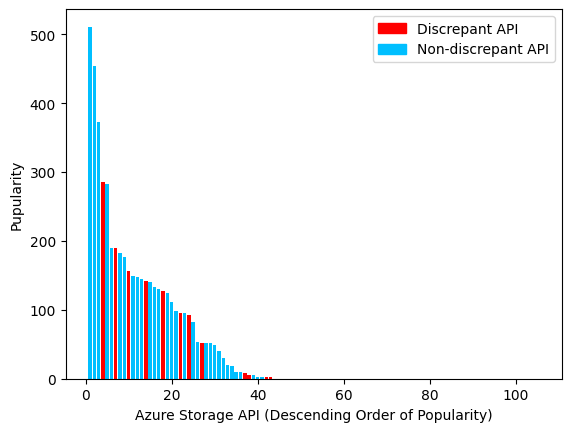

In [20]:
fig,ax = plt.subplots()
METHODS_COUNT = {k: v for k, v in sorted(METHODS_COUNT.items(), key=lambda item: item[1], reverse=True)}
x_axis = range(1, 106)
bar_color = ['red' if x in DISCREPANT_METHODS else 'deepskyblue' for x in METHODS_COUNT]
plt.bar(x_axis, list(METHODS_COUNT.values()) + [0 for i in range(105 - len(METHODS_COUNT))], color=bar_color)
plt.xlabel("Azure Storage API (Descending Order of Popularity)")
plt.ylabel("Pupularity")
# x_ticks = list(range(0, len(x_axis), 10)) + [len(x_axis)]
# ax.set_xticks(x_ticks)
# x_ticks[-1] = f'{len(x_axis)}...115'
# ax.set_xticklabels(x_ticks)
colors = {'Discrepant API':'red', 'Non-discrepant API':'deepskyblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig("azure_api_popularity.pdf", format="pdf")
plt.show()

In [21]:
import seaborn as sns
import pandas as pd

In [39]:
METHODS_COUNT = {k: v for k, v in sorted(METHODS_COUNT.items(), key=lambda item: item[1], reverse=True)}
METHODS_COUNT

{'Table_Create': 511,
 'Table_QueryEntities': 454,
 'Table_InsertEntity': 373,
 'Table_Delete': 286,
 'Table_Batch': 282,
 'Container_Create': 190,
 'BlockBlob_Upload': 190,
 'Queue_Create': 183,
 'Messages_Dequeue': 176,
 'Queue_Delete': 157,
 'Blob_GetProperties': 149,
 'Blob_Download': 147,
 'Table_UpdateEntity': 145,
 'Container_Delete': 142,
 'Messages_Enqueue': 140,
 'Container_GetPropertiesWithHead': 133,
 'MessageId_Delete': 130,
 'Blob_AcquireLease': 128,
 'Table_QueryEntitiesWithPartitionAndRowKey': 124,
 'Blob_ReleaseLease': 111,
 'Queue_GetPropertiesWithHead': 99,
 'Container_AcquireLease': 96,
 'Container_RenewLease': 96,
 'Container_ListBlobFlatSegment': 92,
 'Table_MergeEntityWithMerge': 83,
 'Table_DeleteEntity': 53,
 'Service_ListContainersSegment': 52,
 'Service_ListQueuesSegment': 52,
 'Table_Query': 52,
 'Blob_RenewLease': 49,
 'Table_MergeEntity': 40,
 'Container_GetProperties': 30,
 'Blob_Delete': 20,
 'Messages_Clear': 18,
 'Container_GetAccessPolicy': 10,
 'Blob

In [40]:
len(METHODS_COUNT)

43

In [23]:
while len(METHODS_COUNT) < 105:
    METHODS_COUNT[f'place_holder_{len(METHODS_COUNT)}'] = 0
df_pop = pd.DataFrame({
    'API': METHODS_COUNT.keys(),
    'Popularity': METHODS_COUNT.values(),
})


In [32]:
discrepand_method_sorted = []
for method in METHODS_COUNT:
    if method in DISCREPANT_METHODS:
        discrepand_method_sorted.append((method, METHODS_COUNT[method]))
discrepand_method_sorted

[('Table_Delete', 286),
 ('BlockBlob_Upload', 190),
 ('Queue_Delete', 157),
 ('Container_Delete', 142),
 ('Blob_AcquireLease', 128),
 ('Container_AcquireLease', 96),
 ('Container_ListBlobFlatSegment', 92),
 ('Service_ListContainersSegment', 52),
 ('Container_SetAccessPolicy', 8),
 ('Messages_Peek', 6),
 ('Container_ListBlobHierarchySegment', 2),
 ('Blob_ChangeLease', 2)]

In [24]:
df_pop

,API,Popularity
0,Table_Create,511
1,Table_QueryEntities,454
2,Table_InsertEntity,373
3,Table_Delete,286
4,Table_Batch,282
...,...,...
100,place_holder_100,0
101,place_holder_101,0
102,place_holder_102,0
103,place_holder_103,0


In [25]:
bar_color = ['red' if x in DISCREPANT_METHODS else 'deepskyblue' for x in METHODS_COUNT]
colors = {'Discrepant API':'red', 'Non-discrepant API':'deepskyblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

In [26]:
len(bar_color)

105

/var/folders/fy/x_86p0r53zl9w0cqtc30w4fh0000gn/T/ipykernel_85493/2894239242.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pop_plt = sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color)


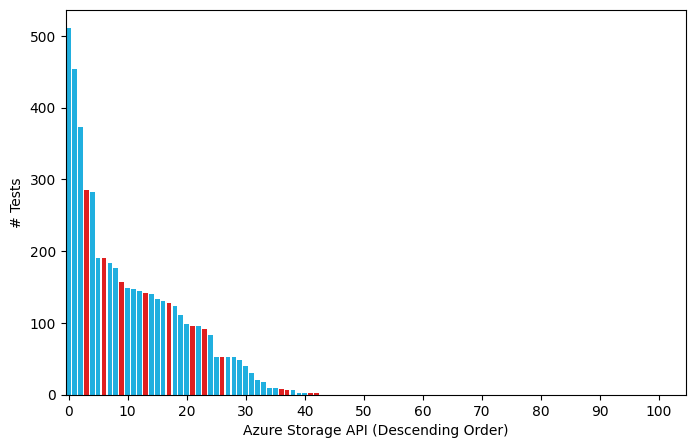

In [34]:
pop_plt = sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color)
pop_plt.set_xlabel("Azure Storage API (Descending Order)")
pop_plt.set_ylabel("# Tests")
pop_plt.set_xticks(range(0, len(df_pop), 10))
pop_plt.figure.set_size_inches(8, 5)
# pop_plt.set_ylim((0, 300))
# pop_plt.set_ymargin(1)
# pop_plt.legend(handles, labels)
# for p,data in zip(ax.patches, df_pop['Popularity']):
#     if int(data) > 230:
#         pop_plt.annotate(data, xy=(p.get_x() + p.get_width() / 2, 230),ha='center', va='bottom', rotation=90)
# for p,data in zip(ax.patches, df_pop['API']):
#     if data in DISCREPANT_METHODS:
#         pop_plt.annotate(data, xy=(p.get_x() + p.get_width() / 2, 0),ha='center', va='bottom', rotation=90)
# pop_plt.set_ylim(0,230)

In [35]:
pop_plt.figure.savefig("azure_api_tests.pdf")

/var/folders/fy/x_86p0r53zl9w0cqtc30w4fh0000gn/T/ipykernel_95225/85636666.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color, ax = ax_top)
/var/folders/fy/x_86p0r53zl9w0cqtc30w4fh0000gn/T/ipykernel_95225/85636666.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color, ax = ax_bottom)


(0.0, 300.0)

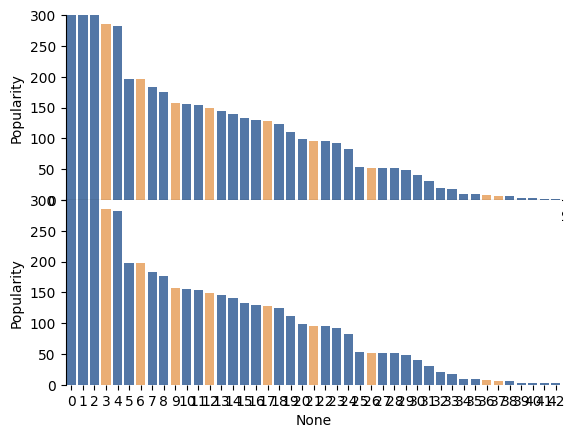

In [110]:
f, (ax_bottom, ax_top) = plt.subplots(ncols=1, nrows=2, sharey=True)
sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color, ax = ax_top)
sns.barplot(df_pop, x = df_pop.index, y = 'Popularity', palette=bar_color, ax = ax_bottom)

plt.subplots_adjust(wspace=0, hspace=0)
sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)
ax.set_ylim((0, 300))
# ax2.set_ylim(bottom=350)

(0.0, 300.0)

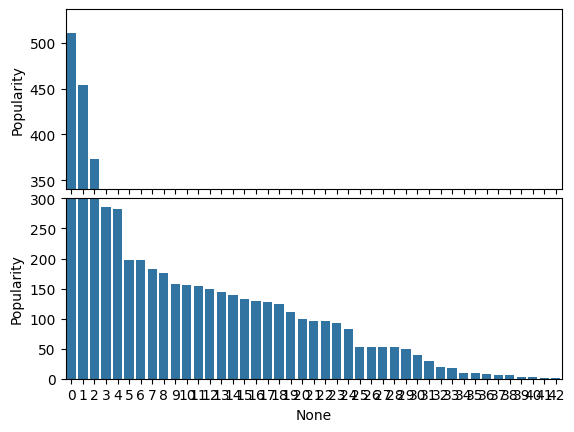

In [117]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
exercise = sns.load_dataset("exercise")
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.05})
sns.barplot(x=df_pop.index, y="Popularity",data=df_pop, ax=ax_top)
sns.barplot(x=df_pop.index, y="Popularity",data=df_pop, ax=ax_bottom)
ax_top.set_ylim(bottom=340)   # those limits are fake
ax_bottom.set_ylim(0,300)

# sns.despine(ax=ax_bottom)
# sns.despine(ax=ax_top, bottom=True)

# ax = ax_top
# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

# ax2 = ax_bottom
# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

# #remove one of the legend
# ax_bottom.legend_.remove()
# plt.show()